In [32]:
import math
import random
import json

# Constants for simulation
OVERLAY_RADIUS = 100         # in meters: radius of true/perturbed circle
POKEMON_MAX_RADIUS = 1000    # in meters: radius around fixed center to generate Pokémon
POKEMON_SPACING =50        # in meters: spacing for generating Pokémon positions

def load_noise_pairs(filename):
    """
    Load noise pairs from a JSON file.
    The JSON file is expected to contain an array of pairs, e.g.:
      [[noise_x1, noise_y1], [noise_x2, noise_y2], ...]
    """
    with open(filename, 'r') as f:
        noise_data = json.load(f)
    # Return as list of (noise_x, noise_y) tuples
    return [(pair[0], pair[1]) for pair in noise_data]

def distance_meters(lat1, lon1, lat2, lon2):
    """
    Approximate the distance between two lat/lon points in meters using an equirectangular approximation.
    This is sufficient for short distances.
    """
    # Average latitude in radians for longitude scaling
    avg_lat = math.radians((lat1 + lat2) / 2)
    # Convert differences to meters (1 degree latitude ~111320 m)
    dx = (lon2 - lon1) * (111320 * math.cos(avg_lat))
    dy = (lat2 - lat1) * 111320
    return math.sqrt(dx * dx + dy * dy)

def add_noise_to_location(lat, lon, noise_x, noise_y):
    """
    Given a true location (lat, lon) and noise in meters, convert the noise to degrees and add it.
    """
    # 1 degree latitude is approximately 111320 meters.
    delta_lat = noise_y / 111320.0
    # For longitude, adjust by the cosine of the latitude.
    delta_lon = noise_x / (111320.0 * math.cos(math.radians(lat)))
    return lat + delta_lat, lon + delta_lon

def generate_uniform_pokemon_positions(center, max_radius, spacing):
    """
    Generate a list of (lat, lon) positions uniformly within a circle (center, max_radius).
    This follows a grid-like approach similar to your Kotlin code.
    """
    center_lat, center_lon = center
    positions = []
    # Conversion factors from meters to degrees (latitude constant, longitude depends on latitude)
    meter_to_deg_lat = 1.0 / 111320.0
    meter_to_deg_lon = 1.0 / (111320.0 * math.cos(math.radians(center_lat)))
    
    radius_deg_lat = max_radius * meter_to_deg_lat
    radius_deg_lon = max_radius * meter_to_deg_lon
    min_lat = center_lat - radius_deg_lat
    max_lat = center_lat + radius_deg_lat
    min_lon = center_lon - radius_deg_lon
    max_lon = center_lon + radius_deg_lon
    spacing_deg_lat = spacing * meter_to_deg_lat
    spacing_deg_lon = spacing * meter_to_deg_lon

    lat = min_lat
    while lat <= max_lat:
        lon = min_lon
        while lon <= max_lon:
            # Check if this candidate lies within the max_radius circle
            if distance_meters(center_lat, center_lon, lat, lon) <= max_radius:
                positions.append((lat, lon))
            lon += spacing_deg_lon
        lat += spacing_deg_lat
    return positions

def simulate_show_rate(true_location, noise_pairs, pokemon_positions, iterations=100):
    """
    For a given true location, simulate multiple perturbed locations by randomly picking noise pairs.
    For each perturbed sample, compute the show rate as:
       (number of Pokémon in both true and perturbed circle) / (number in true circle) * 100
    Returns the average show rate over the specified number of iterations.
    """
    true_lat, true_lon = true_location
    rates = []
    for _ in range(iterations):
        # Pick a random noise pair and compute the perturbed location.
        noise_x, noise_y = random.choice(noise_pairs)
        perturbed_lat, perturbed_lon = add_noise_to_location(true_lat, true_lon, noise_x, noise_y)
        
        count_true = 0
        count_intersection = 0
        
        # For each Pokémon, check if it lies within the true circle and perturbed circle.
        for p_lat, p_lon in pokemon_positions:
            if distance_meters(true_lat, true_lon, p_lat, p_lon) <= OVERLAY_RADIUS:
                count_true += 1
                if distance_meters(perturbed_lat, perturbed_lon, p_lat, p_lon) <= OVERLAY_RADIUS:
                    count_intersection += 1
        # Calculate the show rate for this iteration.
        show_rate = (count_intersection / count_true) * 100 if count_true > 0 else 0
        rates.append(show_rate)
    return sum(rates) / len(rates)

def simulate_for_mechanism(noise_filename, true_locations, fixed_pokemon_center, iterations_per_location=100):
    """
    Run the simulation for a given mechanism (specified via its noise file).
    For each true location, the function computes the average show rate over the given iterations.
    Then it returns the overall average across all true locations.
    """
    noise_pairs = load_noise_pairs(noise_filename)
    # Generate Pokémon positions once (static anchors) around the fixed center.
    pokemon_positions = generate_uniform_pokemon_positions(fixed_pokemon_center, POKEMON_MAX_RADIUS, POKEMON_SPACING)
    location_rates = []
    for loc in true_locations:
        rate = simulate_show_rate(loc, noise_pairs, pokemon_positions, iterations=iterations_per_location)
        location_rates.append(rate)
        print(f"True location {loc} average show rate: {rate:.2f}%")
    overall_average = sum(location_rates) / len(location_rates) if location_rates else 0
    return overall_average

def main():
    # Fixed Pokémon generation center (e.g., RIT, Rochester, NY)
    fixed_pokemon_center = (43.083789, -77.680391)
    
    # Define several true locations (you can adjust these as needed)
    true_locations = [
        (43.083789, -77.680391),  # Location A
        (43.083900, -77.680500),  # Location B
        (43.083500, -77.680200),  # Location C
        (43.083850, -77.680450),  # Location D
        (43.083600, -77.680600)   # Location E
    ]
    
    # Define noise file names for the two mechanisms.
    laplace_noise_file = r"C:\Users\ss6365\AndroidStudioProjects\testformap2\app\src\main\assets\noise_laplace_low.json"
    staircase_noise_file = r"C:\Users\ss6365\AndroidStudioProjects\testformap2\app\src\main\assets\noise_staircase_low.json"
    
    print("Simulating for Laplace mechanism:")
    avg_show_rate_laplace = simulate_for_mechanism(
        laplace_noise_file, true_locations, fixed_pokemon_center, iterations_per_location=100
    )
    print(f"Overall average show rate for Laplace: {avg_show_rate_laplace:.2f}%\n")
    
    print("Simulating for Staircase mechanism:")
    avg_show_rate_staircase = simulate_for_mechanism(
        staircase_noise_file, true_locations, fixed_pokemon_center, iterations_per_location=100
    )
    print(f"Overall average show rate for Staircase: {avg_show_rate_staircase:.2f}%")

if __name__ == "__main__":
    main()


Simulating for Laplace mechanism:
True location (43.083789, -77.680391) average show rate: 91.18%
True location (43.0839, -77.6805) average show rate: 98.15%
True location (43.0835, -77.6802) average show rate: 100.00%
True location (43.08385, -77.68045) average show rate: 99.91%
True location (43.0836, -77.6806) average show rate: 99.31%
Overall average show rate for Laplace: 97.71%

Simulating for Staircase mechanism:
True location (43.083789, -77.680391) average show rate: 90.27%
True location (43.0839, -77.6805) average show rate: 99.23%
True location (43.0835, -77.6802) average show rate: 100.00%
True location (43.08385, -77.68045) average show rate: 100.00%
True location (43.0836, -77.6806) average show rate: 99.92%
Overall average show rate for Staircase: 97.89%


In [33]:
import math
import random
import json

# Constants for simulation
OVERLAY_RADIUS = 100         # in meters: radius of true/perturbed circle
POKEMON_MAX_RADIUS = 1000    # in meters: radius around fixed center to generate Pokémon
POKEMON_SPACING = 50         # in meters: spacing for generating Pokémon positions

def load_noise_pairs(filename):
    """
    Load noise pairs from a JSON file.
    The JSON file is expected to contain an array of pairs, e.g.:
      [[noise_x1, noise_y1], [noise_x2, noise_y2], ...]
    """
    with open(filename, 'r') as f:
        noise_data = json.load(f)
    # Return as list of (noise_x, noise_y) tuples
    return [(pair[0], pair[1]) for pair in noise_data]

def distance_meters(lat1, lon1, lat2, lon2):
    """
    Approximate the distance between two lat/lon points in meters using an equirectangular approximation.
    This is sufficient for short distances.
    """
    # Average latitude in radians for longitude scaling
    avg_lat = math.radians((lat1 + lat2) / 2)
    # Convert differences to meters (1 degree latitude ~111320 m)
    dx = (lon2 - lon1) * (111320 * math.cos(avg_lat))
    dy = (lat2 - lat1) * 111320
    return math.sqrt(dx * dx + dy * dy)

def add_noise_to_location(lat, lon, noise_x, noise_y):
    """
    Given a true location (lat, lon) and noise in meters, convert the noise to degrees and add it.
    """
    # 1 degree latitude is approximately 111320 meters.
    delta_lat = noise_y / 111320.0
    # For longitude, adjust by the cosine of the latitude.
    delta_lon = noise_x / (111320.0 * math.cos(math.radians(lat)))
    return lat + delta_lat, lon + delta_lon

def generate_uniform_pokemon_positions(center, max_radius, spacing):
    """
    Generate a list of (lat, lon) positions uniformly within a circle (center, max_radius).
    This follows a grid-like approach similar to your Kotlin code.
    """
    center_lat, center_lon = center
    positions = []
    # Conversion factors from meters to degrees (latitude constant, longitude depends on latitude)
    meter_to_deg_lat = 1.0 / 111320.0
    meter_to_deg_lon = 1.0 / (111320.0 * math.cos(math.radians(center_lat)))
    
    radius_deg_lat = max_radius * meter_to_deg_lat
    radius_deg_lon = max_radius * meter_to_deg_lon
    min_lat = center_lat - radius_deg_lat
    max_lat = center_lat + radius_deg_lat
    min_lon = center_lon - radius_deg_lon
    max_lon = center_lon + radius_deg_lon
    spacing_deg_lat = spacing * meter_to_deg_lat
    spacing_deg_lon = spacing * meter_to_deg_lon

    lat = min_lat
    while lat <= max_lat:
        lon = min_lon
        while lon <= max_lon:
            # Check if this candidate lies within the max_radius circle
            if distance_meters(center_lat, center_lon, lat, lon) <= max_radius:
                positions.append((lat, lon))
            lon += spacing_deg_lon
        lat += spacing_deg_lat
    return positions

def simulate_show_rate(true_location, noise_pairs, pokemon_positions, iterations=100):
    """
    For a given true location, simulate multiple perturbed locations by randomly picking noise pairs.
    For each perturbed sample, compute the show rate as:
       (number of Pokémon in both true and perturbed circle) / (number in true circle) * 100
    Returns the average show rate over the specified number of iterations.
    """
    true_lat, true_lon = true_location
    rates = []
    for _ in range(iterations):
        # Pick a random noise pair and compute the perturbed location.
        noise_x, noise_y = random.choice(noise_pairs)
        perturbed_lat, perturbed_lon = add_noise_to_location(true_lat, true_lon, noise_x, noise_y)
        
        count_true = 0
        count_intersection = 0
        
        # For each Pokémon, check if it lies within the true circle and perturbed circle.
        for p_lat, p_lon in pokemon_positions:
            if distance_meters(true_lat, true_lon, p_lat, p_lon) <= OVERLAY_RADIUS:
                count_true += 1
                if distance_meters(perturbed_lat, perturbed_lon, p_lat, p_lon) <= OVERLAY_RADIUS:
                    count_intersection += 1
        # Calculate the show rate for this iteration.
        show_rate = (count_intersection / count_true) * 100 if count_true > 0 else 0
        rates.append(show_rate)
    return sum(rates) / len(rates)

def simulate_for_mechanism(noise_filename, true_locations, fixed_pokemon_center, iterations_per_location=100):
    """
    Run the simulation for a given mechanism (specified via its noise file).
    For each true location, the function computes the average show rate over the given iterations.
    Then it returns the overall average across all true locations.
    """
    noise_pairs = load_noise_pairs(noise_filename)
    # Generate Pokémon positions once (static anchors) around the fixed center.
    pokemon_positions = generate_uniform_pokemon_positions(fixed_pokemon_center, POKEMON_MAX_RADIUS, POKEMON_SPACING)
    location_rates = []
    for loc in true_locations:
        rate = simulate_show_rate(loc, noise_pairs, pokemon_positions, iterations=iterations_per_location)
        location_rates.append(rate)
        print(f"True location {loc} average show rate: {rate:.2f}%")
    overall_average = sum(location_rates) / len(location_rates) if location_rates else 0
    return overall_average

def main():
    # Fixed Pokémon generation center (e.g., RIT, Rochester, NY)
    fixed_pokemon_center = (43.083789, -77.680391)
    
    # Define several true locations (you can adjust these as needed)
    true_locations = [
        (43.083789, -77.680391),  # Location A
        (43.083900, -77.680500),  # Location B
        (43.083500, -77.680200),  # Location C
        (43.083850, -77.680450),  # Location D
        (43.083600, -77.680600)   # Location E
    ]
    
    # Define noise file names for the two mechanisms.
    laplace_noise_file = r"C:\Users\ss6365\AndroidStudioProjects\testformap2\app\src\main\assets\noise_laplace_medium.json"
    staircase_noise_file = r"C:\Users\ss6365\AndroidStudioProjects\testformap2\app\src\main\assets\noise_staircase_medium.json"
    
    print("Simulating for Laplace mechanism:")
    avg_show_rate_laplace = simulate_for_mechanism(
        laplace_noise_file, true_locations, fixed_pokemon_center, iterations_per_location=100
    )
    print(f"Overall average show rate for Laplace: {avg_show_rate_laplace:.2f}%\n")
    
    print("Simulating for Staircase mechanism:")
    avg_show_rate_staircase = simulate_for_mechanism(
        staircase_noise_file, true_locations, fixed_pokemon_center, iterations_per_location=100
    )
    print(f"Overall average show rate for Staircase: {avg_show_rate_staircase:.2f}%")

if __name__ == "__main__":
    main()


Simulating for Laplace mechanism:
True location (43.083789, -77.680391) average show rate: 91.82%
True location (43.0839, -77.6805) average show rate: 97.08%
True location (43.0835, -77.6802) average show rate: 99.54%
True location (43.08385, -77.68045) average show rate: 99.00%
True location (43.0836, -77.6806) average show rate: 98.38%
Overall average show rate for Laplace: 97.16%

Simulating for Staircase mechanism:
True location (43.083789, -77.680391) average show rate: 90.73%
True location (43.0839, -77.6805) average show rate: 97.92%
True location (43.0835, -77.6802) average show rate: 99.92%
True location (43.08385, -77.68045) average show rate: 99.91%
True location (43.0836, -77.6806) average show rate: 98.77%
Overall average show rate for Staircase: 97.45%


In [34]:
import math
import random
import json

# Constants for simulation
OVERLAY_RADIUS = 100         # in meters: radius of true/perturbed circle
POKEMON_MAX_RADIUS = 1000    # in meters: radius around fixed center to generate Pokémon
POKEMON_SPACING = 50         # in meters: spacing for generating Pokémon positions
def load_noise_pairs(filename):
    """
    Load noise pairs from a JSON file.
    The JSON file is expected to contain an array of pairs, e.g.:
      [[noise_x1, noise_y1], [noise_x2, noise_y2], ...]
    """
    with open(filename, 'r') as f:
        noise_data = json.load(f)
    # Return as list of (noise_x, noise_y) tuples
    return [(pair[0], pair[1]) for pair in noise_data]

def distance_meters(lat1, lon1, lat2, lon2):
    """
    Approximate the distance between two lat/lon points in meters using an equirectangular approximation.
    This is sufficient for short distances.
    """
    # Average latitude in radians for longitude scaling
    avg_lat = math.radians((lat1 + lat2) / 2)
    # Convert differences to meters (1 degree latitude ~111320 m)
    dx = (lon2 - lon1) * (111320 * math.cos(avg_lat))
    dy = (lat2 - lat1) * 111320
    return math.sqrt(dx * dx + dy * dy)

def add_noise_to_location(lat, lon, noise_x, noise_y):
    """
    Given a true location (lat, lon) and noise in meters, convert the noise to degrees and add it.
    """
    # 1 degree latitude is approximately 111320 meters.
    delta_lat = noise_y / 111320.0
    # For longitude, adjust by the cosine of the latitude.
    delta_lon = noise_x / (111320.0 * math.cos(math.radians(lat)))
    return lat + delta_lat, lon + delta_lon

def generate_uniform_pokemon_positions(center, max_radius, spacing):
    """
    Generate a list of (lat, lon) positions uniformly within a circle (center, max_radius).
    This follows a grid-like approach similar to your Kotlin code.
    """
    center_lat, center_lon = center
    positions = []
    # Conversion factors from meters to degrees (latitude constant, longitude depends on latitude)
    meter_to_deg_lat = 1.0 / 111320.0
    meter_to_deg_lon = 1.0 / (111320.0 * math.cos(math.radians(center_lat)))
    
    radius_deg_lat = max_radius * meter_to_deg_lat
    radius_deg_lon = max_radius * meter_to_deg_lon
    min_lat = center_lat - radius_deg_lat
    max_lat = center_lat + radius_deg_lat
    min_lon = center_lon - radius_deg_lon
    max_lon = center_lon + radius_deg_lon
    spacing_deg_lat = spacing * meter_to_deg_lat
    spacing_deg_lon = spacing * meter_to_deg_lon

    lat = min_lat
    while lat <= max_lat:
        lon = min_lon
        while lon <= max_lon:
            # Check if this candidate lies within the max_radius circle
            if distance_meters(center_lat, center_lon, lat, lon) <= max_radius:
                positions.append((lat, lon))
            lon += spacing_deg_lon
        lat += spacing_deg_lat
    return positions

def simulate_show_rate(true_location, noise_pairs, pokemon_positions, iterations=100):
    """
    For a given true location, simulate multiple perturbed locations by randomly picking noise pairs.
    For each perturbed sample, compute the show rate as:
       (number of Pokémon in both true and perturbed circle) / (number in true circle) * 100
    Returns the average show rate over the specified number of iterations.
    """
    true_lat, true_lon = true_location
    rates = []
    for _ in range(iterations):
        # Pick a random noise pair and compute the perturbed location.
        noise_x, noise_y = random.choice(noise_pairs)
        perturbed_lat, perturbed_lon = add_noise_to_location(true_lat, true_lon, noise_x, noise_y)
        
        count_true = 0
        count_intersection = 0
        
        # For each Pokémon, check if it lies within the true circle and perturbed circle.
        for p_lat, p_lon in pokemon_positions:
            if distance_meters(true_lat, true_lon, p_lat, p_lon) <= OVERLAY_RADIUS:
                count_true += 1
                if distance_meters(perturbed_lat, perturbed_lon, p_lat, p_lon) <= OVERLAY_RADIUS:
                    count_intersection += 1
        # Calculate the show rate for this iteration.
        show_rate = (count_intersection / count_true) * 100 if count_true > 0 else 0
        rates.append(show_rate)
    return sum(rates) / len(rates)

def simulate_for_mechanism(noise_filename, true_locations, fixed_pokemon_center, iterations_per_location=100):
    """
    Run the simulation for a given mechanism (specified via its noise file).
    For each true location, the function computes the average show rate over the given iterations.
    Then it returns the overall average across all true locations.
    """
    noise_pairs = load_noise_pairs(noise_filename)
    # Generate Pokémon positions once (static anchors) around the fixed center.
    pokemon_positions = generate_uniform_pokemon_positions(fixed_pokemon_center, POKEMON_MAX_RADIUS, POKEMON_SPACING)
    location_rates = []
    for loc in true_locations:
        rate = simulate_show_rate(loc, noise_pairs, pokemon_positions, iterations=iterations_per_location)
        location_rates.append(rate)
        print(f"True location {loc} average show rate: {rate:.2f}%")
    overall_average = sum(location_rates) / len(location_rates) if location_rates else 0
    return overall_average

def main():
    # Fixed Pokémon generation center (e.g., RIT, Rochester, NY)
    fixed_pokemon_center = (43.083789, -77.680391)
    
    # Define several true locations (you can adjust these as needed)
    true_locations = [
        (43.083789, -77.680391),  # Location A
        (43.083900, -77.680500),  # Location B
        (43.083500, -77.680200),  # Location C
        (43.083850, -77.680450),  # Location D
        (43.083600, -77.680600)   # Location E
    ]
    
    # Define noise file names for the two mechanisms.
    laplace_noise_file = r"C:\Users\ss6365\AndroidStudioProjects\testformap2\app\src\main\assets\noise_laplace_high.json"
    staircase_noise_file = r"C:\Users\ss6365\AndroidStudioProjects\testformap2\app\src\main\assets\noise_staircase_high.json"
    
    print("Simulating for Laplace mechanism:")
    avg_show_rate_laplace = simulate_for_mechanism(
        laplace_noise_file, true_locations, fixed_pokemon_center, iterations_per_location=100
    )
    print(f"Overall average show rate for Laplace: {avg_show_rate_laplace:.2f}%\n")
    
    print("Simulating for Staircase mechanism:")
    avg_show_rate_staircase = simulate_for_mechanism(
        staircase_noise_file, true_locations, fixed_pokemon_center, iterations_per_location=100
    )
    print(f"Overall average show rate for Staircase: {avg_show_rate_staircase:.2f}%")

if __name__ == "__main__":
    main()


Simulating for Laplace mechanism:
True location (43.083789, -77.680391) average show rate: 88.18%
True location (43.0839, -77.6805) average show rate: 88.00%
True location (43.0835, -77.6802) average show rate: 89.23%
True location (43.08385, -77.68045) average show rate: 90.18%
True location (43.0836, -77.6806) average show rate: 87.38%
Overall average show rate for Laplace: 88.60%

Simulating for Staircase mechanism:
True location (43.083789, -77.680391) average show rate: 89.00%
True location (43.0839, -77.6805) average show rate: 91.08%
True location (43.0835, -77.6802) average show rate: 94.85%
True location (43.08385, -77.68045) average show rate: 95.73%
True location (43.0836, -77.6806) average show rate: 95.38%
Overall average show rate for Staircase: 93.21%


In [39]:
from geopy.distance import geodesic

# Example coordinates (lat, lon)
point1 =  (43.083868, -77.680411)  # Dhaka
point2 = (43.083835, -77.680452)

distance_meters = geodesic(point1, point2).meters
print(f"Distance: {distance_meters:.2f} meters")


Distance: 4.96 meters


In [38]:
import random
from geopy.distance import distance
from geopy.point import Point

def generate_trajectory(start_lat, start_lon, step_distance_m, m):
    points = []
    current_point = Point(start_lat, start_lon)
    points.append((start_lat, start_lon))

    for _ in range(m - 1):
        # Random direction in degrees (0 to 360)
        bearing = random.uniform(0, 360)
        # Generate next point at specified distance and bearing
        next_point = distance(meters=step_distance_m).destination(current_point, bearing)
        points.append((next_point.latitude, next_point.longitude))
        current_point = next_point

    return points

# Example usage
trajectory = generate_trajectory(43.083789, -77.680391, 5, 10)  # 10 points, each 5 meters apart
for idx, (lat, lon) in enumerate(trajectory):
    print(f"Point {idx+1}: ({lat:.6f}, {lon:.6f})")


Point 1: (43.083789, -77.680391)
Point 2: (43.083821, -77.680348)
Point 3: (43.083866, -77.680350)
Point 4: (43.083868, -77.680411)
Point 5: (43.083835, -77.680452)
Point 6: (43.083830, -77.680513)
Point 7: (43.083785, -77.680513)
Point 8: (43.083828, -77.680532)
Point 9: (43.083785, -77.680515)
Point 10: (43.083828, -77.680532)


In [40]:
import random
from geopy.distance import distance
from geopy.point import Point

def generate_trajectory(start_lat, start_lon, step_distance_m, m):
    points = []
    current_point = Point(start_lat, start_lon)
    points.append((start_lat, start_lon))

    for _ in range(m - 1):
        # Random direction in degrees (0 to 360)
        bearing = random.uniform(0, 360)
        # Generate next point at specified distance and bearing
        next_point = distance(meters=step_distance_m).destination(current_point, bearing)
        points.append((next_point.latitude, next_point.longitude))
        current_point = next_point

    return points

# Example usage
trajectory = generate_trajectory(43.083789, -77.680391, 6, 10)  # 10 points, each 5 meters apart
for idx, (lat, lon) in enumerate(trajectory):
    print(f"Point {idx+1}: ({lat:.6f}, {lon:.6f})")


Point 1: (43.083789, -77.680391)
Point 2: (43.083825, -77.680336)
Point 3: (43.083773, -77.680315)
Point 4: (43.083827, -77.680314)
Point 5: (43.083823, -77.680241)
Point 6: (43.083870, -77.680278)
Point 7: (43.083818, -77.680299)
Point 8: (43.083814, -77.680373)
Point 9: (43.083858, -77.680330)
Point 10: (43.083908, -77.680301)


In [41]:
import random
from geopy.distance import distance
from geopy.point import Point

def generate_trajectory(start_lat, start_lon, step_distance_m, m):
    points = []
    current_point = Point(start_lat, start_lon)
    points.append((start_lat, start_lon))

    for _ in range(m - 1):
        # Random direction in degrees (0 to 360)
        bearing = random.uniform(0, 360)
        # Generate next point at specified distance and bearing
        next_point = distance(meters=step_distance_m).destination(current_point, bearing)
        points.append((next_point.latitude, next_point.longitude))
        current_point = next_point

    return points

# Example usage
trajectory = generate_trajectory(43.083789, -77.680391, 7, 10)  # 10 points, each 5 meters apart
for idx, (lat, lon) in enumerate(trajectory):
    print(f"Point {idx+1}: ({lat:.6f}, {lon:.6f})")


Point 1: (43.083789, -77.680391)
Point 2: (43.083797, -77.680476)
Point 3: (43.083734, -77.680464)
Point 4: (43.083796, -77.680448)
Point 5: (43.083738, -77.680415)
Point 6: (43.083687, -77.680465)
Point 7: (43.083645, -77.680401)
Point 8: (43.083590, -77.680358)
Point 9: (43.083591, -77.680273)
Point 10: (43.083535, -77.680310)


In [42]:
import random
from geopy.distance import distance
from geopy.point import Point

def generate_trajectory(start_lat, start_lon, step_distance_m, m):
    points = []
    current_point = Point(start_lat, start_lon)
    points.append((start_lat, start_lon))

    for _ in range(m - 1):
        # Random direction in degrees (0 to 360)
        bearing = random.uniform(0, 360)
        # Generate next point at specified distance and bearing
        next_point = distance(meters=step_distance_m).destination(current_point, bearing)
        points.append((next_point.latitude, next_point.longitude))
        current_point = next_point

    return points

# Example usage
trajectory = generate_trajectory(43.083789, -77.680391, 8, 10)  # 10 points, each 5 meters apart
for idx, (lat, lon) in enumerate(trajectory):
    print(f"Point {idx+1}: ({lat:.6f}, {lon:.6f})")


Point 1: (43.083789, -77.680391)
Point 2: (43.083853, -77.680346)
Point 3: (43.083781, -77.680353)
Point 4: (43.083716, -77.680395)
Point 5: (43.083785, -77.680425)
Point 6: (43.083738, -77.680349)
Point 7: (43.083731, -77.680252)
Point 8: (43.083677, -77.680318)
Point 9: (43.083606, -77.680300)
Point 10: (43.083537, -77.680327)


In [43]:
import random
from geopy.distance import distance
from geopy.point import Point

def generate_trajectory(start_lat, start_lon, step_distance_m, m):
    points = []
    current_point = Point(start_lat, start_lon)
    points.append((start_lat, start_lon))

    for _ in range(m - 1):
        # Random direction in degrees (0 to 360)
        bearing = random.uniform(0, 360)
        # Generate next point at specified distance and bearing
        next_point = distance(meters=step_distance_m).destination(current_point, bearing)
        points.append((next_point.latitude, next_point.longitude))
        current_point = next_point

    return points

# Example usage
trajectory = generate_trajectory(43.083789, -77.680391, 9, 10)  # 10 points, each 5 meters apart
for idx, (lat, lon) in enumerate(trajectory):
    print(f"Point {idx+1}: ({lat:.6f}, {lon:.6f})")


Point 1: (43.083789, -77.680391)
Point 2: (43.083862, -77.680342)
Point 3: (43.083831, -77.680444)
Point 4: (43.083863, -77.680546)
Point 5: (43.083819, -77.680453)
Point 6: (43.083793, -77.680557)
Point 7: (43.083718, -77.680598)
Point 8: (43.083781, -77.680529)
Point 9: (43.083730, -77.680443)
Point 10: (43.083776, -77.680351)


In [44]:
import random
from geopy.distance import distance
from geopy.point import Point

def generate_trajectory(start_lat, start_lon, step_distance_m, m):
    points = []
    current_point = Point(start_lat, start_lon)
    points.append((start_lat, start_lon))

    for _ in range(m - 1):
        # Random direction in degrees (0 to 360)
        bearing = random.uniform(0, 360)
        # Generate next point at specified distance and bearing
        next_point = distance(meters=step_distance_m).destination(current_point, bearing)
        points.append((next_point.latitude, next_point.longitude))
        current_point = next_point

    return points

# Example usage
trajectory = generate_trajectory(43.083789, -77.680391, 10, 10)  # 10 points, each 5 meters apart
for idx, (lat, lon) in enumerate(trajectory):
    print(f"Point {idx+1}: ({lat:.6f}, {lon:.6f})")


Point 1: (43.083789, -77.680391)
Point 2: (43.083813, -77.680273)
Point 3: (43.083724, -77.680289)
Point 4: (43.083735, -77.680167)
Point 5: (43.083719, -77.680288)
Point 6: (43.083801, -77.680238)
Point 7: (43.083817, -77.680359)
Point 8: (43.083748, -77.680280)
Point 9: (43.083659, -77.680300)
Point 10: (43.083572, -77.680331)


In [55]:
import math
import random
import json

# Constants for simulation
OVERLAY_RADIUS = 100         # in meters: radius of true/perturbed circle
POKEMON_MAX_RADIUS = 1000    # in meters: radius around fixed center to generate Pokémon
POKEMON_SPACING = 50        # in meters: spacing for generating Pokémon positions

def load_noise_pairs(filename):
    """
    Load noise pairs from a JSON file.
    The JSON file is expected to contain an array of pairs, e.g.:
      [[noise_x1, noise_y1], [noise_x2, noise_y2], ...]
    """
    with open(filename, 'r') as f:
        noise_data = json.load(f)
    # Return as list of (noise_x, noise_y) tuples
    return [(pair[0], pair[1]) for pair in noise_data]

def distance_meters(lat1, lon1, lat2, lon2):
    """
    Approximate the distance between two lat/lon points in meters using an equirectangular approximation.
    This is sufficient for short distances.
    """
    # Average latitude in radians for longitude scaling
    avg_lat = math.radians((lat1 + lat2) / 2)
    dx = (lon2 - lon1) * (111320 * math.cos(avg_lat))
    dy = (lat2 - lat1) * 111320
    return math.sqrt(dx * dx + dy * dy)

def add_noise_to_location(lat, lon, noise_x, noise_y):
    """
    Given a true location (lat, lon) and noise in meters, convert the noise to degrees and add it.
    """
    delta_lat = noise_y / 111320.0
    delta_lon = noise_x / (111320.0 * math.cos(math.radians(lat)))
    return lat + delta_lat, lon + delta_lon

def generate_uniform_pokemon_positions(center, max_radius, spacing):
    """
    Generate a list of (lat, lon) positions uniformly within a circle (center, max_radius).
    This follows a grid-like approach similar to your Kotlin code.
    """
    center_lat, center_lon = center
    positions = []
    meter_to_deg_lat = 1.0 / 111320.0
    meter_to_deg_lon = 1.0 / (111320.0 * math.cos(math.radians(center_lat)))
    
    radius_deg_lat = max_radius * meter_to_deg_lat
    radius_deg_lon = max_radius * meter_to_deg_lon
    min_lat = center_lat - radius_deg_lat
    max_lat = center_lat + radius_deg_lat
    min_lon = center_lon - radius_deg_lon
    max_lon = center_lon + radius_deg_lon
    spacing_deg_lat = spacing * meter_to_deg_lat
    spacing_deg_lon = spacing * meter_to_deg_lon

    lat = min_lat
    while lat <= max_lat:
        lon = min_lon
        while lon <= max_lon:
            if distance_meters(center_lat, center_lon, lat, lon) <= max_radius:
                positions.append((lat, lon))
            lon += spacing_deg_lon
        lat += spacing_deg_lat
    return positions

def simulate_show_rate_for_point(true_location, noise_pairs, pokemon_positions, iterations=100):
    """
    For a single true location point, simulate multiple perturbed locations (iterations)
    and accumulate the total number of Pokémon inside the true circle and those also in the perturbed circle.
    Returns a tuple (total_true, total_intersection).
    """
    true_lat, true_lon = true_location
    total_true = 0
    total_intersection = 0
    for _ in range(iterations):
        # Choose a random noise pair
        noise_x, noise_y = random.choice(noise_pairs)
        perturbed_lat, perturbed_lon = add_noise_to_location(true_lat, true_lon, noise_x, noise_y)
        
        # Check every Pokémon against both circles.
        for p_lat, p_lon in pokemon_positions:
            if distance_meters(true_lat, true_lon, p_lat, p_lon) <= OVERLAY_RADIUS:
                total_true += 1
                if distance_meters(perturbed_lat, perturbed_lon, p_lat, p_lon) <= OVERLAY_RADIUS:
                    total_intersection += 1
    return total_true, total_intersection

def simulate_for_users(noise_filename, users_trajectories, fixed_pokemon_center, iterations_per_point=100):
    """
    Run the simulation for a given noise mechanism over multiple users.
    Each user trajectory is a list of true location points.
    For each point, the simulation runs for the specified number of iterations.
    Finally, the function computes a single overall average show rate across all users and points.
    """
    noise_pairs = load_noise_pairs(noise_filename)
    # Generate Pokémon positions once, as they are static.
    pokemon_positions = generate_uniform_pokemon_positions(fixed_pokemon_center, POKEMON_MAX_RADIUS, POKEMON_SPACING)
    
    overall_true = 0
    overall_intersection = 0
    
    for user_index, trajectory in enumerate(users_trajectories):
        print(f"User {user_index + 1} trajectory:")
        user_true = 0
        user_intersection = 0
        for point in trajectory:
            t_true, t_intersection = simulate_show_rate_for_point(point, noise_pairs, pokemon_positions, iterations=iterations_per_point)
            user_true += t_true
            user_intersection += t_intersection
            if t_true > 0:
                point_show_rate = (t_intersection / t_true) * 100
            else:
                point_show_rate = 0
            print(f"  True point {point}: average show rate over {iterations_per_point} iterations: {point_show_rate:.2f}%")
        if user_true > 0:
            user_show_rate = (user_intersection / user_true) * 100
        else:
            user_show_rate = 0
        print(f"User {user_index+1} overall average show rate: {user_show_rate:.2f}%\n")
        overall_true += user_true
        overall_intersection += user_intersection

    overall_average = (overall_intersection / overall_true) * 100 if overall_true > 0 else 0
    return overall_average

def main():
    # Fixed Pokémon generation center (e.g., RIT, Rochester, NY)
    fixed_pokemon_center = (43.083789, -77.680391)
    
    # Provide trajectories for 5 users.
    # Each user has a trajectory of 10 true location points.
    # For demonstration, these are slight variations around the fixed center.
    
    user_A = [
        (43.083789, -77.680391),
        (43.083821, -77.680348),
        (43.083866, -77.680350),
        (43.083868, -77.680411),
        (43.083835, -77.680452),
        (43.083830, -77.680513),
         (43.083785, -77.680513),
        (43.083828, -77.680532),
        (43.083785, -77.680515),
        (43.083828, -77.680532)
    ]

    user_B = [
        (43.083789, -77.680391),
        (43.083825, -77.680336),
        (43.083773, -77.680315),
        (43.083827, -77.680314),
        (43.083823, -77.680241),
        (43.083870, -77.680278),
        (43.083818, -77.680299),
        (43.083814, -77.680373),
        (43.083858, -77.680330),
        (43.083908, -77.680301)
    ]
 
    
    user_C = [
        (43.083789, -77.680391),
        (43.083797, -77.680476),
        (43.083734, -77.680464),
        (43.083796, -77.680448),
        (43.083738, -77.680415),
        (43.083687, -77.680465),
        (43.083645, -77.680401),
        (43.083590, -77.680358),
        (43.083591, -77.680273),
        (43.083535, -77.680310)
    ]

    
    
    user_D = [
        (43.083789, -77.680391),
        (43.083862, -77.680342),
       (43.083831, -77.680444),
        (43.083863, -77.680546),
        (43.083819, -77.680453),
        (43.083793, -77.680557),
        (43.083718, -77.680598),
        (43.083781, -77.680529),
        (43.083730, -77.680443),
        (43.083776, -77.680351)
    ]


    
    user_E = [
        (43.083789, -77.680391),
        (43.083813, -77.680273),
        (43.083724, -77.680289),
        (43.083735, -77.680167),
        (43.083719, -77.680288),
        (43.083801, -77.680238),
        (43.083817, -77.680359),
        (43.083748, -77.680280),
        (43.083659, -77.680300),
        (43.083572, -77.680331)
    ]

    # Combine trajectories for all 5 users into a list.
    users_trajectories = [user_A, user_B, user_C, user_D, user_E]
    
    # Define noise file names for the two mechanisms.
    laplace_noise_file = r"C:\Users\ss6365\AndroidStudioProjects\testformap2\app\src\main\assets\noise_laplace_low.json"
    staircase_noise_file = r"C:\Users\ss6365\AndroidStudioProjects\testformap2\app\src\main\assets\noise_staircase_low.json"
    
    print("Simulating for Laplace mechanism:")
    overall_show_rate_laplace = simulate_for_users(
        laplace_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Laplace (across all users & trajectory points): {overall_show_rate_laplace:.2f}%\n")
    
    print("Simulating for Staircase mechanism:")
    overall_show_rate_staircase = simulate_for_users(
        staircase_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Staircase (across all users & trajectory points): {overall_show_rate_staircase:.2f}%")

if __name__ == "__main__":
    main()


Simulating for Laplace mechanism:
User 1 trajectory:
  True point (43.083789, -77.680391): average show rate over 100 iterations: 90.55%
  True point (43.083821, -77.680348): average show rate over 100 iterations: 99.27%
  True point (43.083866, -77.68035): average show rate over 100 iterations: 99.55%
  True point (43.083868, -77.680411): average show rate over 100 iterations: 98.45%
  True point (43.083835, -77.680452): average show rate over 100 iterations: 99.91%
  True point (43.08383, -77.680513): average show rate over 100 iterations: 99.91%
  True point (43.083785, -77.680513): average show rate over 100 iterations: 100.00%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 96.42%
  True point (43.083785, -77.680515): average show rate over 100 iterations: 100.00%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 96.92%
User 1 overall average show rate: 98.04%

User 2 trajectory:
  True point (43.083789, -77.680391): average 

In [56]:
import math
import random
import json

# Constants for simulation
OVERLAY_RADIUS = 100         # in meters: radius of true/perturbed circle
POKEMON_MAX_RADIUS = 1000    # in meters: radius around fixed center to generate Pokémon
POKEMON_SPACING = 50        # in meters: spacing for generating Pokémon positions

def load_noise_pairs(filename):
    """
    Load noise pairs from a JSON file.
    The JSON file is expected to contain an array of pairs, e.g.:
      [[noise_x1, noise_y1], [noise_x2, noise_y2], ...]
    """
    with open(filename, 'r') as f:
        noise_data = json.load(f)
    # Return as list of (noise_x, noise_y) tuples
    return [(pair[0], pair[1]) for pair in noise_data]

def distance_meters(lat1, lon1, lat2, lon2):
    """
    Approximate the distance between two lat/lon points in meters using an equirectangular approximation.
    This is sufficient for short distances.
    """
    # Average latitude in radians for longitude scaling
    avg_lat = math.radians((lat1 + lat2) / 2)
    dx = (lon2 - lon1) * (111320 * math.cos(avg_lat))
    dy = (lat2 - lat1) * 111320
    return math.sqrt(dx * dx + dy * dy)

def add_noise_to_location(lat, lon, noise_x, noise_y):
    """
    Given a true location (lat, lon) and noise in meters, convert the noise to degrees and add it.
    """
    delta_lat = noise_y / 111320.0
    delta_lon = noise_x / (111320.0 * math.cos(math.radians(lat)))
    return lat + delta_lat, lon + delta_lon

def generate_uniform_pokemon_positions(center, max_radius, spacing):
    """
    Generate a list of (lat, lon) positions uniformly within a circle (center, max_radius).
    This follows a grid-like approach similar to your Kotlin code.
    """
    center_lat, center_lon = center
    positions = []
    meter_to_deg_lat = 1.0 / 111320.0
    meter_to_deg_lon = 1.0 / (111320.0 * math.cos(math.radians(center_lat)))
    
    radius_deg_lat = max_radius * meter_to_deg_lat
    radius_deg_lon = max_radius * meter_to_deg_lon
    min_lat = center_lat - radius_deg_lat
    max_lat = center_lat + radius_deg_lat
    min_lon = center_lon - radius_deg_lon
    max_lon = center_lon + radius_deg_lon
    spacing_deg_lat = spacing * meter_to_deg_lat
    spacing_deg_lon = spacing * meter_to_deg_lon

    lat = min_lat
    while lat <= max_lat:
        lon = min_lon
        while lon <= max_lon:
            if distance_meters(center_lat, center_lon, lat, lon) <= max_radius:
                positions.append((lat, lon))
            lon += spacing_deg_lon
        lat += spacing_deg_lat
    return positions

def simulate_show_rate_for_point(true_location, noise_pairs, pokemon_positions, iterations=100):
    """
    For a single true location point, simulate multiple perturbed locations (iterations)
    and accumulate the total number of Pokémon inside the true circle and those also in the perturbed circle.
    Returns a tuple (total_true, total_intersection).
    """
    true_lat, true_lon = true_location
    total_true = 0
    total_intersection = 0
    for _ in range(iterations):
        # Choose a random noise pair
        noise_x, noise_y = random.choice(noise_pairs)
        perturbed_lat, perturbed_lon = add_noise_to_location(true_lat, true_lon, noise_x, noise_y)
        
        # Check every Pokémon against both circles.
        for p_lat, p_lon in pokemon_positions:
            if distance_meters(true_lat, true_lon, p_lat, p_lon) <= OVERLAY_RADIUS:
                total_true += 1
                if distance_meters(perturbed_lat, perturbed_lon, p_lat, p_lon) <= OVERLAY_RADIUS:
                    total_intersection += 1
    return total_true, total_intersection

def simulate_for_users(noise_filename, users_trajectories, fixed_pokemon_center, iterations_per_point=100):
    """
    Run the simulation for a given noise mechanism over multiple users.
    Each user trajectory is a list of true location points.
    For each point, the simulation runs for the specified number of iterations.
    Finally, the function computes a single overall average show rate across all users and points.
    """
    noise_pairs = load_noise_pairs(noise_filename)
    # Generate Pokémon positions once, as they are static.
    pokemon_positions = generate_uniform_pokemon_positions(fixed_pokemon_center, POKEMON_MAX_RADIUS, POKEMON_SPACING)
    
    overall_true = 0
    overall_intersection = 0
    
    for user_index, trajectory in enumerate(users_trajectories):
        print(f"User {user_index + 1} trajectory:")
        user_true = 0
        user_intersection = 0
        for point in trajectory:
            t_true, t_intersection = simulate_show_rate_for_point(point, noise_pairs, pokemon_positions, iterations=iterations_per_point)
            user_true += t_true
            user_intersection += t_intersection
            if t_true > 0:
                point_show_rate = (t_intersection / t_true) * 100
            else:
                point_show_rate = 0
            print(f"  True point {point}: average show rate over {iterations_per_point} iterations: {point_show_rate:.2f}%")
        if user_true > 0:
            user_show_rate = (user_intersection / user_true) * 100
        else:
            user_show_rate = 0
        print(f"User {user_index+1} overall average show rate: {user_show_rate:.2f}%\n")
        overall_true += user_true
        overall_intersection += user_intersection

    overall_average = (overall_intersection / overall_true) * 100 if overall_true > 0 else 0
    return overall_average

def main():
    # Fixed Pokémon generation center (e.g., RIT, Rochester, NY)
    fixed_pokemon_center = (43.083789, -77.680391)
    
    # Provide trajectories for 5 users.
    # Each user has a trajectory of 10 true location points.
    # For demonstration, these are slight variations around the fixed center.
    
    user_A = [
        (43.083789, -77.680391),
        (43.083821, -77.680348),
        (43.083866, -77.680350),
        (43.083868, -77.680411),
        (43.083835, -77.680452),
        (43.083830, -77.680513),
         (43.083785, -77.680513),
        (43.083828, -77.680532),
        (43.083785, -77.680515),
        (43.083828, -77.680532)
    ]

    user_B = [
        (43.083789, -77.680391),
        (43.083825, -77.680336),
        (43.083773, -77.680315),
        (43.083827, -77.680314),
        (43.083823, -77.680241),
        (43.083870, -77.680278),
        (43.083818, -77.680299),
        (43.083814, -77.680373),
        (43.083858, -77.680330),
        (43.083908, -77.680301)
    ]
 
    
    user_C = [
        (43.083789, -77.680391),
        (43.083797, -77.680476),
        (43.083734, -77.680464),
        (43.083796, -77.680448),
        (43.083738, -77.680415),
        (43.083687, -77.680465),
        (43.083645, -77.680401),
        (43.083590, -77.680358),
        (43.083591, -77.680273),
        (43.083535, -77.680310)
    ]

    
    
    user_D = [
        (43.083789, -77.680391),
        (43.083862, -77.680342),
       (43.083831, -77.680444),
        (43.083863, -77.680546),
        (43.083819, -77.680453),
        (43.083793, -77.680557),
        (43.083718, -77.680598),
        (43.083781, -77.680529),
        (43.083730, -77.680443),
        (43.083776, -77.680351)
    ]


    
    user_E = [
        (43.083789, -77.680391),
        (43.083813, -77.680273),
        (43.083724, -77.680289),
        (43.083735, -77.680167),
        (43.083719, -77.680288),
        (43.083801, -77.680238),
        (43.083817, -77.680359),
        (43.083748, -77.680280),
        (43.083659, -77.680300),
        (43.083572, -77.680331)
    ]

    # Combine trajectories for all 5 users into a list.
    users_trajectories = [user_A, user_B, user_C, user_D, user_E]
    
    # Define noise file names for the two mechanisms.
    laplace_noise_file = r"C:\Users\ss6365\AndroidStudioProjects\testformap2\app\src\main\assets\noise_laplace_medium.json"
    staircase_noise_file = r"C:\Users\ss6365\AndroidStudioProjects\testformap2\app\src\main\assets\noise_staircase_medium.json"
    
    print("Simulating for Laplace mechanism:")
    overall_show_rate_laplace = simulate_for_users(
        laplace_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Laplace (across all users & trajectory points): {overall_show_rate_laplace:.2f}%\n")
    
    print("Simulating for Staircase mechanism:")
    overall_show_rate_staircase = simulate_for_users(
        staircase_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Staircase (across all users & trajectory points): {overall_show_rate_staircase:.2f}%")

if __name__ == "__main__":
    main()


Simulating for Laplace mechanism:
User 1 trajectory:
  True point (43.083789, -77.680391): average show rate over 100 iterations: 89.55%
  True point (43.083821, -77.680348): average show rate over 100 iterations: 92.64%
  True point (43.083866, -77.68035): average show rate over 100 iterations: 95.36%
  True point (43.083868, -77.680411): average show rate over 100 iterations: 94.27%
  True point (43.083835, -77.680452): average show rate over 100 iterations: 94.27%
  True point (43.08383, -77.680513): average show rate over 100 iterations: 96.18%
  True point (43.083785, -77.680513): average show rate over 100 iterations: 98.40%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 91.67%
  True point (43.083785, -77.680515): average show rate over 100 iterations: 99.00%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 93.33%
User 1 overall average show rate: 94.35%

User 2 trajectory:
  True point (43.083789, -77.680391): average sh

In [57]:
import math
import random
import json

# Constants for simulation
OVERLAY_RADIUS = 100         # in meters: radius of true/perturbed circle
POKEMON_MAX_RADIUS = 1000    # in meters: radius around fixed center to generate Pokémon
POKEMON_SPACING = 50        # in meters: spacing for generating Pokémon positions

def load_noise_pairs(filename):
    """
    Load noise pairs from a JSON file.
    The JSON file is expected to contain an array of pairs, e.g.:
      [[noise_x1, noise_y1], [noise_x2, noise_y2], ...]
    """
    with open(filename, 'r') as f:
        noise_data = json.load(f)
    # Return as list of (noise_x, noise_y) tuples
    return [(pair[0], pair[1]) for pair in noise_data]

def distance_meters(lat1, lon1, lat2, lon2):
    """
    Approximate the distance between two lat/lon points in meters using an equirectangular approximation.
    This is sufficient for short distances.
    """
    # Average latitude in radians for longitude scaling
    avg_lat = math.radians((lat1 + lat2) / 2)
    dx = (lon2 - lon1) * (111320 * math.cos(avg_lat))
    dy = (lat2 - lat1) * 111320
    return math.sqrt(dx * dx + dy * dy)

def add_noise_to_location(lat, lon, noise_x, noise_y):
    """
    Given a true location (lat, lon) and noise in meters, convert the noise to degrees and add it.
    """
    delta_lat = noise_y / 111320.0
    delta_lon = noise_x / (111320.0 * math.cos(math.radians(lat)))
    return lat + delta_lat, lon + delta_lon

def generate_uniform_pokemon_positions(center, max_radius, spacing):
    """
    Generate a list of (lat, lon) positions uniformly within a circle (center, max_radius).
    This follows a grid-like approach similar to your Kotlin code.
    """
    center_lat, center_lon = center
    positions = []
    meter_to_deg_lat = 1.0 / 111320.0
    meter_to_deg_lon = 1.0 / (111320.0 * math.cos(math.radians(center_lat)))
    
    radius_deg_lat = max_radius * meter_to_deg_lat
    radius_deg_lon = max_radius * meter_to_deg_lon
    min_lat = center_lat - radius_deg_lat
    max_lat = center_lat + radius_deg_lat
    min_lon = center_lon - radius_deg_lon
    max_lon = center_lon + radius_deg_lon
    spacing_deg_lat = spacing * meter_to_deg_lat
    spacing_deg_lon = spacing * meter_to_deg_lon

    lat = min_lat
    while lat <= max_lat:
        lon = min_lon
        while lon <= max_lon:
            if distance_meters(center_lat, center_lon, lat, lon) <= max_radius:
                positions.append((lat, lon))
            lon += spacing_deg_lon
        lat += spacing_deg_lat
    return positions

def simulate_show_rate_for_point(true_location, noise_pairs, pokemon_positions, iterations=100):
    """
    For a single true location point, simulate multiple perturbed locations (iterations)
    and accumulate the total number of Pokémon inside the true circle and those also in the perturbed circle.
    Returns a tuple (total_true, total_intersection).
    """
    true_lat, true_lon = true_location
    total_true = 0
    total_intersection = 0
    for _ in range(iterations):
        # Choose a random noise pair
        noise_x, noise_y = random.choice(noise_pairs)
        perturbed_lat, perturbed_lon = add_noise_to_location(true_lat, true_lon, noise_x, noise_y)
        
        # Check every Pokémon against both circles.
        for p_lat, p_lon in pokemon_positions:
            if distance_meters(true_lat, true_lon, p_lat, p_lon) <= OVERLAY_RADIUS:
                total_true += 1
                if distance_meters(perturbed_lat, perturbed_lon, p_lat, p_lon) <= OVERLAY_RADIUS:
                    total_intersection += 1
    return total_true, total_intersection

def simulate_for_users(noise_filename, users_trajectories, fixed_pokemon_center, iterations_per_point=100):
    """
    Run the simulation for a given noise mechanism over multiple users.
    Each user trajectory is a list of true location points.
    For each point, the simulation runs for the specified number of iterations.
    Finally, the function computes a single overall average show rate across all users and points.
    """
    noise_pairs = load_noise_pairs(noise_filename)
    # Generate Pokémon positions once, as they are static.
    pokemon_positions = generate_uniform_pokemon_positions(fixed_pokemon_center, POKEMON_MAX_RADIUS, POKEMON_SPACING)
    
    overall_true = 0
    overall_intersection = 0
    
    for user_index, trajectory in enumerate(users_trajectories):
        print(f"User {user_index + 1} trajectory:")
        user_true = 0
        user_intersection = 0
        for point in trajectory:
            t_true, t_intersection = simulate_show_rate_for_point(point, noise_pairs, pokemon_positions, iterations=iterations_per_point)
            user_true += t_true
            user_intersection += t_intersection
            if t_true > 0:
                point_show_rate = (t_intersection / t_true) * 100
            else:
                point_show_rate = 0
            print(f"  True point {point}: average show rate over {iterations_per_point} iterations: {point_show_rate:.2f}%")
        if user_true > 0:
            user_show_rate = (user_intersection / user_true) * 100
        else:
            user_show_rate = 0
        print(f"User {user_index+1} overall average show rate: {user_show_rate:.2f}%\n")
        overall_true += user_true
        overall_intersection += user_intersection

    overall_average = (overall_intersection / overall_true) * 100 if overall_true > 0 else 0
    return overall_average

def main():
    # Fixed Pokémon generation center (e.g., RIT, Rochester, NY)
    fixed_pokemon_center = (43.083789, -77.680391)
    
    # Provide trajectories for 5 users.
    # Each user has a trajectory of 10 true location points.
    # For demonstration, these are slight variations around the fixed center.
    
    user_A = [
        (43.083789, -77.680391),
        (43.083821, -77.680348),
        (43.083866, -77.680350),
        (43.083868, -77.680411),
        (43.083835, -77.680452),
        (43.083830, -77.680513),
         (43.083785, -77.680513),
        (43.083828, -77.680532),
        (43.083785, -77.680515),
        (43.083828, -77.680532)
    ]

    user_B = [
        (43.083789, -77.680391),
        (43.083825, -77.680336),
        (43.083773, -77.680315),
        (43.083827, -77.680314),
        (43.083823, -77.680241),
        (43.083870, -77.680278),
        (43.083818, -77.680299),
        (43.083814, -77.680373),
        (43.083858, -77.680330),
        (43.083908, -77.680301)
    ]
 
    
    user_C = [
        (43.083789, -77.680391),
        (43.083797, -77.680476),
        (43.083734, -77.680464),
        (43.083796, -77.680448),
        (43.083738, -77.680415),
        (43.083687, -77.680465),
        (43.083645, -77.680401),
        (43.083590, -77.680358),
        (43.083591, -77.680273),
        (43.083535, -77.680310)
    ]

    
    
    user_D = [
        (43.083789, -77.680391),
        (43.083862, -77.680342),
       (43.083831, -77.680444),
        (43.083863, -77.680546),
        (43.083819, -77.680453),
        (43.083793, -77.680557),
        (43.083718, -77.680598),
        (43.083781, -77.680529),
        (43.083730, -77.680443),
        (43.083776, -77.680351)
    ]


    
    user_E = [
        (43.083789, -77.680391),
        (43.083813, -77.680273),
        (43.083724, -77.680289),
        (43.083735, -77.680167),
        (43.083719, -77.680288),
        (43.083801, -77.680238),
        (43.083817, -77.680359),
        (43.083748, -77.680280),
        (43.083659, -77.680300),
        (43.083572, -77.680331)
    ]

    # Combine trajectories for all 5 users into a list.
    users_trajectories = [user_A, user_B, user_C, user_D, user_E]
    
    # Define noise file names for the two mechanisms.
    laplace_noise_file = r"C:\Users\ss6365\AndroidStudioProjects\testformap2\app\src\main\assets\noise_laplace_high.json"
    staircase_noise_file = r"C:\Users\ss6365\AndroidStudioProjects\testformap2\app\src\main\assets\noise_staircase_high.json"
    
    print("Simulating for Laplace mechanism:")
    overall_show_rate_laplace = simulate_for_users(
        laplace_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Laplace (across all users & trajectory points): {overall_show_rate_laplace:.2f}%\n")
    
    print("Simulating for Staircase mechanism:")
    overall_show_rate_staircase = simulate_for_users(
        staircase_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Staircase (across all users & trajectory points): {overall_show_rate_staircase:.2f}%")

if __name__ == "__main__":
    main()


Simulating for Laplace mechanism:
User 1 trajectory:
  True point (43.083789, -77.680391): average show rate over 100 iterations: 87.09%
  True point (43.083821, -77.680348): average show rate over 100 iterations: 89.64%
  True point (43.083866, -77.68035): average show rate over 100 iterations: 88.91%
  True point (43.083868, -77.680411): average show rate over 100 iterations: 91.45%
  True point (43.083835, -77.680452): average show rate over 100 iterations: 90.91%
  True point (43.08383, -77.680513): average show rate over 100 iterations: 88.82%
  True point (43.083785, -77.680513): average show rate over 100 iterations: 94.50%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 87.25%
  True point (43.083785, -77.680515): average show rate over 100 iterations: 94.00%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 88.50%
User 1 overall average show rate: 89.99%

User 2 trajectory:
  True point (43.083789, -77.680391): average sh

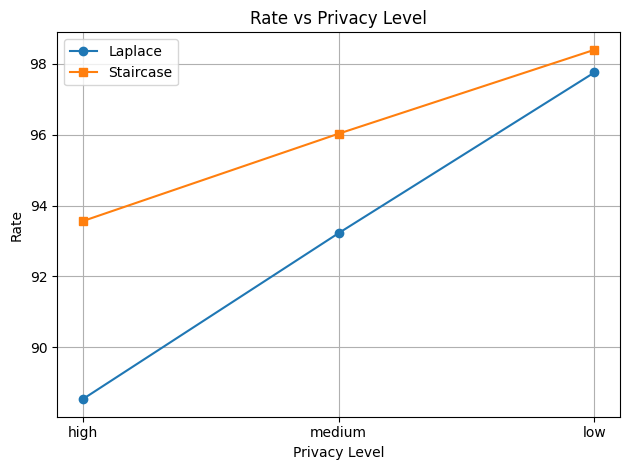

In [59]:
import matplotlib.pyplot as plt

# Example input lists (replace with your actual data)
list1 = [88.53, 93.22, 97.76]  # First line
list2 = [93.56, 96.03, 98.40]  # Second line

# X-axis labels
x_labels = ['high', 'medium', 'low']
x = range(len(x_labels))

# Plot
plt.plot(x, list1, marker='o', label='Laplace')
plt.plot(x, list2, marker='s', label='Staircase')

# Formatting
plt.xticks(x, x_labels)
plt.xlabel('Privacy Level')
plt.ylabel('Rate')
plt.title('Rate vs Privacy Level')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


In [12]:
import math
import random
import json

# Constants for simulation
OVERLAY_RADIUS = 100         # in meters: radius of true/perturbed circle
POKEMON_MAX_RADIUS = 1000    # in meters: radius around fixed center to generate Pokémon
POKEMON_SPACING = 100        # in meters: spacing for generating Pokémon positions

def load_noise_pairs(filename):
    """
    Load noise pairs from a JSON file.
    The JSON file is expected to contain an array of pairs, e.g.:
      [[noise_x1, noise_y1], [noise_x2, noise_y2], ...]
    """
    with open(filename, 'r') as f:
        noise_data = json.load(f)
    # Return as list of (noise_x, noise_y) tuples
    return [(pair[0], pair[1]) for pair in noise_data]

def distance_meters(lat1, lon1, lat2, lon2):
    """
    Approximate the distance between two lat/lon points in meters using an equirectangular approximation.
    This is sufficient for short distances.
    """
    # Average latitude in radians for longitude scaling
    avg_lat = math.radians((lat1 + lat2) / 2)
    dx = (lon2 - lon1) * (111320 * math.cos(avg_lat))
    dy = (lat2 - lat1) * 111320
    return math.sqrt(dx * dx + dy * dy)

def add_noise_to_location(lat, lon, noise_x, noise_y):
    """
    Given a true location (lat, lon) and noise in meters, convert the noise to degrees and add it.
    """
    delta_lat = noise_y / 111320.0
    delta_lon = noise_x / (111320.0 * math.cos(math.radians(lat)))
    return lat + delta_lat, lon + delta_lon

def generate_uniform_pokemon_positions(center, max_radius, spacing):
    """
    Generate a list of (lat, lon) positions uniformly within a circle (center, max_radius).
    This follows a grid-like approach similar to your Kotlin code.
    """
    center_lat, center_lon = center
    positions = []
    meter_to_deg_lat = 1.0 / 111320.0
    meter_to_deg_lon = 1.0 / (111320.0 * math.cos(math.radians(center_lat)))
    
    radius_deg_lat = max_radius * meter_to_deg_lat
    radius_deg_lon = max_radius * meter_to_deg_lon
    min_lat = center_lat - radius_deg_lat
    max_lat = center_lat + radius_deg_lat
    min_lon = center_lon - radius_deg_lon
    max_lon = center_lon + radius_deg_lon
    spacing_deg_lat = spacing * meter_to_deg_lat
    spacing_deg_lon = spacing * meter_to_deg_lon

    lat = min_lat
    while lat <= max_lat:
        lon = min_lon
        while lon <= max_lon:
            if distance_meters(center_lat, center_lon, lat, lon) <= max_radius:
                positions.append((lat, lon))
            lon += spacing_deg_lon
        lat += spacing_deg_lat
    return positions

def simulate_show_rate_for_point(true_location, noise_pairs, pokemon_positions, iterations=100):
    """
    For a single true location point, simulate multiple perturbed locations (iterations)
    and accumulate the total number of Pokémon inside the true circle and those also in the perturbed circle.
    Returns a tuple (total_true, total_intersection).
    """
    true_lat, true_lon = true_location
    total_true = 0
    total_intersection = 0
    for _ in range(iterations):
        # Choose a random noise pair
        noise_x, noise_y = random.choice(noise_pairs)
        perturbed_lat, perturbed_lon = add_noise_to_location(true_lat, true_lon, noise_x, noise_y)
        
        # Check every Pokémon against both circles.
        for p_lat, p_lon in pokemon_positions:
            if distance_meters(true_lat, true_lon, p_lat, p_lon) <= OVERLAY_RADIUS:
                total_true += 1
                if distance_meters(perturbed_lat, perturbed_lon, p_lat, p_lon) <= OVERLAY_RADIUS:
                    total_intersection += 1
    return total_true, total_intersection

def simulate_for_users(noise_filename, users_trajectories, fixed_pokemon_center, iterations_per_point=100):
    """
    Run the simulation for a given noise mechanism over multiple users.
    Each user trajectory is a list of true location points.
    For each point, the simulation runs for the specified number of iterations.
    Finally, the function computes a single overall average show rate across all users and points.
    """
    noise_pairs = load_noise_pairs(noise_filename)
    # Generate Pokémon positions once, as they are static.
    pokemon_positions = generate_uniform_pokemon_positions(fixed_pokemon_center, POKEMON_MAX_RADIUS, POKEMON_SPACING)
    
    overall_true = 0
    overall_intersection = 0
    
    for user_index, trajectory in enumerate(users_trajectories):
        print(f"User {user_index + 1} trajectory:")
        user_true = 0
        user_intersection = 0
        for point in trajectory:
            t_true, t_intersection = simulate_show_rate_for_point(point, noise_pairs, pokemon_positions, iterations=iterations_per_point)
            user_true += t_true
            user_intersection += t_intersection
            if t_true > 0:
                point_show_rate = (t_intersection / t_true) * 100
            else:
                point_show_rate = 0
            print(f"  True point {point}: average show rate over {iterations_per_point} iterations: {point_show_rate:.2f}%")
        if user_true > 0:
            user_show_rate = (user_intersection / user_true) * 100
        else:
            user_show_rate = 0
        print(f"User {user_index+1} overall average show rate: {user_show_rate:.2f}%\n")
        overall_true += user_true
        overall_intersection += user_intersection

    overall_average = (overall_intersection / overall_true) * 100 if overall_true > 0 else 0
    return overall_average

def main():
    # Fixed Pokémon generation center (e.g., RIT, Rochester, NY)
    fixed_pokemon_center = (43.083789, -77.680391)
    
    # Provide trajectories for 5 users.
    # Each user has a trajectory of 10 true location points.
    # For demonstration, these are slight variations around the fixed center.
    
    user_A = [
        (43.083789, -77.680391),
        (43.083821, -77.680348),
        (43.083866, -77.680350),
        (43.083868, -77.680411),
        (43.083835, -77.680452),
        (43.083830, -77.680513),
         (43.083785, -77.680513),
        (43.083828, -77.680532),
        (43.083785, -77.680515),
        (43.083828, -77.680532)
    ]

    user_B = [
        (43.083789, -77.680391),
        (43.083825, -77.680336),
        (43.083773, -77.680315),
        (43.083827, -77.680314),
        (43.083823, -77.680241),
        (43.083870, -77.680278),
        (43.083818, -77.680299),
        (43.083814, -77.680373),
        (43.083858, -77.680330),
        (43.083908, -77.680301)
    ]
 
    
    user_C = [
        (43.083789, -77.680391),
        (43.083797, -77.680476),
        (43.083734, -77.680464),
        (43.083796, -77.680448),
        (43.083738, -77.680415),
        (43.083687, -77.680465),
        (43.083645, -77.680401),
        (43.083590, -77.680358),
        (43.083591, -77.680273),
        (43.083535, -77.680310)
    ]

    
    
    user_D = [
        (43.083789, -77.680391),
        (43.083862, -77.680342),
       (43.083831, -77.680444),
        (43.083863, -77.680546),
        (43.083819, -77.680453),
        (43.083793, -77.680557),
        (43.083718, -77.680598),
        (43.083781, -77.680529),
        (43.083730, -77.680443),
        (43.083776, -77.680351)
    ]


    
    user_E = [
        (43.083789, -77.680391),
        (43.083813, -77.680273),
        (43.083724, -77.680289),
        (43.083735, -77.680167),
        (43.083719, -77.680288),
        (43.083801, -77.680238),
        (43.083817, -77.680359),
        (43.083748, -77.680280),
        (43.083659, -77.680300),
        (43.083572, -77.680331)
    ]

    # Combine trajectories for all 5 users into a list.
    users_trajectories = [user_A, user_B, user_C, user_D, user_E]
    
    # Define noise file names for the two mechanisms.
    laplace_noise_file = r"C:\Users\ss6365\Desktop\NOISE_FILES\laplace_0.1.json"
    staircase_noise_file = r"C:\Users\ss6365\Desktop\NOISE_FILES\staircase_0.1.json"
    
    print("Simulating for Laplace mechanism:")
    overall_show_rate_laplace = simulate_for_users(
        laplace_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Laplace (across all users & trajectory points): {overall_show_rate_laplace:.2f}%\n")
    
    print("Simulating for Staircase mechanism:")
    overall_show_rate_staircase = simulate_for_users(
        staircase_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Staircase (across all users & trajectory points): {overall_show_rate_staircase:.2f}%")

if __name__ == "__main__":
    main()


Simulating for Laplace mechanism:
User 1 trajectory:
  True point (43.083789, -77.680391): average show rate over 100 iterations: 64.00%
  True point (43.083821, -77.680348): average show rate over 100 iterations: 67.33%
  True point (43.083866, -77.68035): average show rate over 100 iterations: 75.33%
  True point (43.083868, -77.680411): average show rate over 100 iterations: 74.67%
  True point (43.083835, -77.680452): average show rate over 100 iterations: 76.33%
  True point (43.08383, -77.680513): average show rate over 100 iterations: 81.67%
  True point (43.083785, -77.680513): average show rate over 100 iterations: 83.00%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 73.00%
  True point (43.083785, -77.680515): average show rate over 100 iterations: 88.50%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 78.33%
User 1 overall average show rate: 75.54%

User 2 trajectory:
  True point (43.083789, -77.680391): average sh

In [13]:
def main():
    # Fixed Pokémon generation center (e.g., RIT, Rochester, NY)
    fixed_pokemon_center = (43.083789, -77.680391)
    
    # Provide trajectories for 5 users.
    # Each user has a trajectory of 10 true location points.
    # For demonstration, these are slight variations around the fixed center.
    
    user_A = [
        (43.083789, -77.680391),
        (43.083821, -77.680348),
        (43.083866, -77.680350),
        (43.083868, -77.680411),
        (43.083835, -77.680452),
        (43.083830, -77.680513),
         (43.083785, -77.680513),
        (43.083828, -77.680532),
        (43.083785, -77.680515),
        (43.083828, -77.680532)
    ]

    user_B = [
        (43.083789, -77.680391),
        (43.083825, -77.680336),
        (43.083773, -77.680315),
        (43.083827, -77.680314),
        (43.083823, -77.680241),
        (43.083870, -77.680278),
        (43.083818, -77.680299),
        (43.083814, -77.680373),
        (43.083858, -77.680330),
        (43.083908, -77.680301)
    ]
 
    
    user_C = [
        (43.083789, -77.680391),
        (43.083797, -77.680476),
        (43.083734, -77.680464),
        (43.083796, -77.680448),
        (43.083738, -77.680415),
        (43.083687, -77.680465),
        (43.083645, -77.680401),
        (43.083590, -77.680358),
        (43.083591, -77.680273),
        (43.083535, -77.680310)
    ]

    
    
    user_D = [
        (43.083789, -77.680391),
        (43.083862, -77.680342),
       (43.083831, -77.680444),
        (43.083863, -77.680546),
        (43.083819, -77.680453),
        (43.083793, -77.680557),
        (43.083718, -77.680598),
        (43.083781, -77.680529),
        (43.083730, -77.680443),
        (43.083776, -77.680351)
    ]


    
    user_E = [
        (43.083789, -77.680391),
        (43.083813, -77.680273),
        (43.083724, -77.680289),
        (43.083735, -77.680167),
        (43.083719, -77.680288),
        (43.083801, -77.680238),
        (43.083817, -77.680359),
        (43.083748, -77.680280),
        (43.083659, -77.680300),
        (43.083572, -77.680331)
    ]

    # Combine trajectories for all 5 users into a list.
    users_trajectories = [user_A, user_B, user_C, user_D, user_E]
    
    # Define noise file names for the two mechanisms.
    laplace_noise_file = r"C:\Users\ss6365\Desktop\NOISE_FILES\laplace_0.2.json"
    staircase_noise_file = r"C:\Users\ss6365\Desktop\NOISE_FILES\staircase_0.2.json"
    
    print("Simulating for Laplace mechanism:")
    overall_show_rate_laplace = simulate_for_users(
        laplace_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Laplace (across all users & trajectory points): {overall_show_rate_laplace:.2f}%\n")
    
    print("Simulating for Staircase mechanism:")
    overall_show_rate_staircase = simulate_for_users(
        staircase_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Staircase (across all users & trajectory points): {overall_show_rate_staircase:.2f}%")

if __name__ == "__main__":
    main()


Simulating for Laplace mechanism:
User 1 trajectory:
  True point (43.083789, -77.680391): average show rate over 100 iterations: 68.33%
  True point (43.083821, -77.680348): average show rate over 100 iterations: 79.67%
  True point (43.083866, -77.68035): average show rate over 100 iterations: 82.00%
  True point (43.083868, -77.680411): average show rate over 100 iterations: 77.33%
  True point (43.083835, -77.680452): average show rate over 100 iterations: 83.67%
  True point (43.08383, -77.680513): average show rate over 100 iterations: 82.33%
  True point (43.083785, -77.680513): average show rate over 100 iterations: 94.50%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 87.67%
  True point (43.083785, -77.680515): average show rate over 100 iterations: 94.50%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 88.00%
User 1 overall average show rate: 83.04%

User 2 trajectory:
  True point (43.083789, -77.680391): average sh

In [14]:
def main():
    # Fixed Pokémon generation center (e.g., RIT, Rochester, NY)
    fixed_pokemon_center = (43.083789, -77.680391)
    
    # Provide trajectories for 5 users.
    # Each user has a trajectory of 10 true location points.
    # For demonstration, these are slight variations around the fixed center.
    
    user_A = [
        (43.083789, -77.680391),
        (43.083821, -77.680348),
        (43.083866, -77.680350),
        (43.083868, -77.680411),
        (43.083835, -77.680452),
        (43.083830, -77.680513),
         (43.083785, -77.680513),
        (43.083828, -77.680532),
        (43.083785, -77.680515),
        (43.083828, -77.680532)
    ]

    user_B = [
        (43.083789, -77.680391),
        (43.083825, -77.680336),
        (43.083773, -77.680315),
        (43.083827, -77.680314),
        (43.083823, -77.680241),
        (43.083870, -77.680278),
        (43.083818, -77.680299),
        (43.083814, -77.680373),
        (43.083858, -77.680330),
        (43.083908, -77.680301)
    ]
 
    
    user_C = [
        (43.083789, -77.680391),
        (43.083797, -77.680476),
        (43.083734, -77.680464),
        (43.083796, -77.680448),
        (43.083738, -77.680415),
        (43.083687, -77.680465),
        (43.083645, -77.680401),
        (43.083590, -77.680358),
        (43.083591, -77.680273),
        (43.083535, -77.680310)
    ]

    
    
    user_D = [
        (43.083789, -77.680391),
        (43.083862, -77.680342),
       (43.083831, -77.680444),
        (43.083863, -77.680546),
        (43.083819, -77.680453),
        (43.083793, -77.680557),
        (43.083718, -77.680598),
        (43.083781, -77.680529),
        (43.083730, -77.680443),
        (43.083776, -77.680351)
    ]


    
    user_E = [
        (43.083789, -77.680391),
        (43.083813, -77.680273),
        (43.083724, -77.680289),
        (43.083735, -77.680167),
        (43.083719, -77.680288),
        (43.083801, -77.680238),
        (43.083817, -77.680359),
        (43.083748, -77.680280),
        (43.083659, -77.680300),
        (43.083572, -77.680331)
    ]

    # Combine trajectories for all 5 users into a list.
    users_trajectories = [user_A, user_B, user_C, user_D, user_E]
    
    # Define noise file names for the two mechanisms.
    laplace_noise_file = r"C:\Users\ss6365\Desktop\NOISE_FILES\laplace_0.5.json"
    staircase_noise_file = r"C:\Users\ss6365\Desktop\NOISE_FILES\staircase_0.5.json"
    
    print("Simulating for Laplace mechanism:")
    overall_show_rate_laplace = simulate_for_users(
        laplace_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Laplace (across all users & trajectory points): {overall_show_rate_laplace:.2f}%\n")
    
    print("Simulating for Staircase mechanism:")
    overall_show_rate_staircase = simulate_for_users(
        staircase_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Staircase (across all users & trajectory points): {overall_show_rate_staircase:.2f}%")

if __name__ == "__main__":
    main()


Simulating for Laplace mechanism:
User 1 trajectory:
  True point (43.083789, -77.680391): average show rate over 100 iterations: 64.67%
  True point (43.083821, -77.680348): average show rate over 100 iterations: 91.33%
  True point (43.083866, -77.68035): average show rate over 100 iterations: 93.00%
  True point (43.083868, -77.680411): average show rate over 100 iterations: 87.00%
  True point (43.083835, -77.680452): average show rate over 100 iterations: 94.00%
  True point (43.08383, -77.680513): average show rate over 100 iterations: 95.67%
  True point (43.083785, -77.680513): average show rate over 100 iterations: 99.50%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 96.67%
  True point (43.083785, -77.680515): average show rate over 100 iterations: 100.00%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 97.67%
User 1 overall average show rate: 91.39%

User 2 trajectory:
  True point (43.083789, -77.680391): average s

In [18]:
def main():
    # Fixed Pokémon generation center (e.g., RIT, Rochester, NY)
    fixed_pokemon_center = (43.083789, -77.680391)
    
    # Provide trajectories for 5 users.
    # Each user has a trajectory of 10 true location points.
    # For demonstration, these are slight variations around the fixed center.
    
    user_A = [
        (43.083789, -77.680391),
        (43.083821, -77.680348),
        (43.083866, -77.680350),
        (43.083868, -77.680411),
        (43.083835, -77.680452),
        (43.083830, -77.680513),
         (43.083785, -77.680513),
        (43.083828, -77.680532),
        (43.083785, -77.680515),
        (43.083828, -77.680532)
    ]

    user_B = [
        (43.083789, -77.680391),
        (43.083825, -77.680336),
        (43.083773, -77.680315),
        (43.083827, -77.680314),
        (43.083823, -77.680241),
        (43.083870, -77.680278),
        (43.083818, -77.680299),
        (43.083814, -77.680373),
        (43.083858, -77.680330),
        (43.083908, -77.680301)
    ]
 
    
    user_C = [
        (43.083789, -77.680391),
        (43.083797, -77.680476),
        (43.083734, -77.680464),
        (43.083796, -77.680448),
        (43.083738, -77.680415),
        (43.083687, -77.680465),
        (43.083645, -77.680401),
        (43.083590, -77.680358),
        (43.083591, -77.680273),
        (43.083535, -77.680310)
    ]

    
    
    user_D = [
        (43.083789, -77.680391),
        (43.083862, -77.680342),
       (43.083831, -77.680444),
        (43.083863, -77.680546),
        (43.083819, -77.680453),
        (43.083793, -77.680557),
        (43.083718, -77.680598),
        (43.083781, -77.680529),
        (43.083730, -77.680443),
        (43.083776, -77.680351)
    ]


    
    user_E = [
        (43.083789, -77.680391),
        (43.083813, -77.680273),
        (43.083724, -77.680289),
        (43.083735, -77.680167),
        (43.083719, -77.680288),
        (43.083801, -77.680238),
        (43.083817, -77.680359),
        (43.083748, -77.680280),
        (43.083659, -77.680300),
        (43.083572, -77.680331)
    ]

    # Combine trajectories for all 5 users into a list.
    users_trajectories = [user_A, user_B, user_C, user_D, user_E]
    
    # Define noise file names for the two mechanisms.
    laplace_noise_file = r"C:\Users\ss6365\Desktop\NOISE_FILES\laplace_1.json"
    staircase_noise_file = r"C:\Users\ss6365\Desktop\NOISE_FILES\staircase_1.json"
    
    print("Simulating for Laplace mechanism:")
    overall_show_rate_laplace = simulate_for_users(
        laplace_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Laplace (across all users & trajectory points): {overall_show_rate_laplace:.2f}%\n")
    
    print("Simulating for Staircase mechanism:")
    overall_show_rate_staircase = simulate_for_users(
        staircase_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Staircase (across all users & trajectory points): {overall_show_rate_staircase:.2f}%")

if __name__ == "__main__":
    main()


Simulating for Laplace mechanism:
User 1 trajectory:
  True point (43.083789, -77.680391): average show rate over 100 iterations: 63.00%
  True point (43.083821, -77.680348): average show rate over 100 iterations: 99.33%
  True point (43.083866, -77.68035): average show rate over 100 iterations: 97.67%
  True point (43.083868, -77.680411): average show rate over 100 iterations: 91.33%
  True point (43.083835, -77.680452): average show rate over 100 iterations: 99.00%
  True point (43.08383, -77.680513): average show rate over 100 iterations: 100.00%
  True point (43.083785, -77.680513): average show rate over 100 iterations: 100.00%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 99.33%
  True point (43.083785, -77.680515): average show rate over 100 iterations: 100.00%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 99.00%
User 1 overall average show rate: 94.50%

User 2 trajectory:
  True point (43.083789, -77.680391): average

In [17]:
def main():
    # Fixed Pokémon generation center (e.g., RIT, Rochester, NY)
    fixed_pokemon_center = (43.083789, -77.680391)
    
    # Provide trajectories for 5 users.
    # Each user has a trajectory of 10 true location points.
    # For demonstration, these are slight variations around the fixed center.
    
    user_A = [
        (43.083789, -77.680391),
        (43.083821, -77.680348),
        (43.083866, -77.680350),
        (43.083868, -77.680411),
        (43.083835, -77.680452),
        (43.083830, -77.680513),
         (43.083785, -77.680513),
        (43.083828, -77.680532),
        (43.083785, -77.680515),
        (43.083828, -77.680532)
    ]

    user_B = [
        (43.083789, -77.680391),
        (43.083825, -77.680336),
        (43.083773, -77.680315),
        (43.083827, -77.680314),
        (43.083823, -77.680241),
        (43.083870, -77.680278),
        (43.083818, -77.680299),
        (43.083814, -77.680373),
        (43.083858, -77.680330),
        (43.083908, -77.680301)
    ]
 
    
    user_C = [
        (43.083789, -77.680391),
        (43.083797, -77.680476),
        (43.083734, -77.680464),
        (43.083796, -77.680448),
        (43.083738, -77.680415),
        (43.083687, -77.680465),
        (43.083645, -77.680401),
        (43.083590, -77.680358),
        (43.083591, -77.680273),
        (43.083535, -77.680310)
    ]

    
    
    user_D = [
        (43.083789, -77.680391),
        (43.083862, -77.680342),
       (43.083831, -77.680444),
        (43.083863, -77.680546),
        (43.083819, -77.680453),
        (43.083793, -77.680557),
        (43.083718, -77.680598),
        (43.083781, -77.680529),
        (43.083730, -77.680443),
        (43.083776, -77.680351)
    ]


    
    user_E = [
        (43.083789, -77.680391),
        (43.083813, -77.680273),
        (43.083724, -77.680289),
        (43.083735, -77.680167),
        (43.083719, -77.680288),
        (43.083801, -77.680238),
        (43.083817, -77.680359),
        (43.083748, -77.680280),
        (43.083659, -77.680300),
        (43.083572, -77.680331)
    ]

    # Combine trajectories for all 5 users into a list.
    users_trajectories = [user_A, user_B, user_C, user_D, user_E]
    
    # Define noise file names for the two mechanisms.
    laplace_noise_file = r"C:\Users\ss6365\Desktop\NOISE_FILES\laplace_2.json"
    staircase_noise_file = r"C:\Users\ss6365\Desktop\NOISE_FILES\staircase_2.json"
    
    print("Simulating for Laplace mechanism:")
    overall_show_rate_laplace = simulate_for_users(
        laplace_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Laplace (across all users & trajectory points): {overall_show_rate_laplace:.2f}%\n")
    
    print("Simulating for Staircase mechanism:")
    overall_show_rate_staircase = simulate_for_users(
        staircase_noise_file, users_trajectories, fixed_pokemon_center, iterations_per_point=100
    )
    print(f"\nOverall average show rate for Staircase (across all users & trajectory points): {overall_show_rate_staircase:.2f}%")

if __name__ == "__main__":
    main()


Simulating for Laplace mechanism:
User 1 trajectory:
  True point (43.083789, -77.680391): average show rate over 100 iterations: 65.00%
  True point (43.083821, -77.680348): average show rate over 100 iterations: 100.00%
  True point (43.083866, -77.68035): average show rate over 100 iterations: 100.00%
  True point (43.083868, -77.680411): average show rate over 100 iterations: 97.33%
  True point (43.083835, -77.680452): average show rate over 100 iterations: 100.00%
  True point (43.08383, -77.680513): average show rate over 100 iterations: 100.00%
  True point (43.083785, -77.680513): average show rate over 100 iterations: 100.00%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 100.00%
  True point (43.083785, -77.680515): average show rate over 100 iterations: 100.00%
  True point (43.083828, -77.680532): average show rate over 100 iterations: 100.00%
User 1 overall average show rate: 95.96%

User 2 trajectory:
  True point (43.083789, -77.680391): av

In [10]:
import math
import random
import json
import pandas as pd
import numpy as np
from haversine import haversine, inverse_haversine, Unit
EARTH_RADIUS = 6371000


def bounded_planar_staircase_mechanism_point(Location, noise_staircase_bounded):
    
    Latitude, Longitude = Location
    y, x = latitude_longitude_to_y_x(Latitude, Longitude)
    Noise_X, Noise_Y = random.choice(noise_staircase_bounded) 
    Perturbed_X = x + Noise_X
    Perturbed_Y = y + Noise_Y 
    Perturbed_Latitude, Perturbed_Longitude = y_x_to_latitude_longitude(Perturbed_Y, Perturbed_X)
    
    return Perturbed_Latitude, Perturbed_Longitude


def planar_staircase_mechanism_point(location, noise_staircase):
    latitude, longitude = location
    y, x = latitude_longitude_to_y_x(latitude, longitude)
    noise_x, noise_y = random.choice(noise_staircase)
    Perturbed_X = x + noise_x
    Perturbed_Y = y + noise_y
    Perturbed_Latitude, Perturbed_Longitude  = y_x_to_latitude_longitude(Perturbed_Y, Perturbed_X)

    return Perturbed_Latitude, Perturbed_Longitude

def intermediate(dataset, noise_staircase_bounded):
    
    dataset = dataset.copy()  # Make a copy to avoid modifying the original DataFrame
    num_locations = len(dataset['latitude'])

    # Initialize intermediate and final reported locations
    dataset['intermediate_lat'] = np.nan
    dataset['intermediate_lon'] = np.nan

    
    # Handle the first location separately
    true_location = (dataset['latitude'][0], dataset['longitude'][0])
    intermediate_location = bounded_planar_staircase_mechanism_point(true_location, noise_staircase_bounded)
    
    #distance_first = haversine(true_location, intermediate_location, unit=Unit.METERS)


    dataset.at[0, 'intermediate_lat'] = intermediate_location[0]
    dataset.at[0, 'intermediate_lon'] = intermediate_location[1]
    #dataset.at[0, 'distance_first'] = distance_first

    
    # Handle subsequent locations
    for i in range(1, num_locations):
        true_location = (dataset.at[i, 'latitude'], dataset.at[i, 'longitude'])
        last_true = (dataset.at[i-1, 'latitude'], dataset.at[i-1, 'longitude'])
        distance = haversine(true_location, last_true, unit=Unit.METERS)
        direction = get_direction(last_true, true_location)
        
        intermediate_location = inverse_haversine(
            (dataset.at[i-1, 'intermediate_lat'], dataset.at[i-1, 'intermediate_lon']),
            distance,
            direction,
            Unit.METERS
        )
        
        dataset.at[i, 'intermediate_lat'] = intermediate_location[0]
        dataset.at[i, 'intermediate_lon'] = intermediate_location[1]
        
        

    return dataset

# Update your existing intermediate function to include the generation of reported locations

def only_reported_locations(dataset, noise_staircase, delta):
    
    #dataset = intermediate(dataset, epsilon, x_interval, bl)  # Assume this generates intermediate locations y1, y2, ..., yn
    
    # Initialize the reported locations column
    dataset['perturbed_latitude'] = np.nan
    dataset['perturbed_longitude'] = np.nan
    
    # Handle the first location separately
#     dataset.at[0, 'perturbed_latitude'], dataset.at[0, 'perturbed_longitude'] = SSLLPM(
#         (dataset.at[0, 'intermediate_lat'], dataset.at[0, 'intermediate_lon'])
#     )
    
    
    dataset.at[0, 'perturbed_latitude'], dataset.at[0, 'perturbed_longitude'] = planar_staircase_mechanism_point(
        (dataset.at[0, 'intermediate_lat'], dataset.at[0, 'intermediate_lon']), noise_staircase)
    
    
    
    
    # Store the current focus point (start with the first point)
    current_focus = (dataset.at[0, 'latitude'], dataset.at[0, 'longitude'])
    current_reported = (dataset.at[0, 'perturbed_latitude'], dataset.at[0, 'perturbed_longitude'])
    
    # Iterate over the remaining locations
    for i in range(1, len(dataset)):
        
        true_location = (dataset.at[i, 'latitude'], dataset.at[i, 'longitude'])
        distance_from_focus = haversine(true_location, current_focus, unit=Unit.METERS)
        
        if distance_from_focus < delta:
            # If the distance is below the threshold, report the same location as the current reported location
            dataset.at[i, 'perturbed_latitude'] = current_reported[0]
            dataset.at[i, 'perturbed_longitude'] = current_reported[1]
        
        else:
            # If the distance is above the threshold, perturb the intermediate location to get the reported location
            dataset.at[i, 'perturbed_latitude'], dataset.at[i, 'perturbed_longitude'] = planar_staircase_mechanism_point(
                (dataset.at[i, 'intermediate_lat'], dataset.at[i, 'intermediate_lon']), noise_staircase
            )
            
            # Update the current focus and reported locations
            current_focus = true_location
            current_reported = (dataset.at[i, 'perturbed_latitude'], dataset.at[i, 'perturbed_longitude'])
    
    return dataset

def latitude_longitude_to_y_x(latitude, longitude):
    x = EARTH_RADIUS * np.radians(longitude)
    y = EARTH_RADIUS * np.radians(latitude)
    return y, x

def y_x_to_latitude_longitude(y, x):
    longitude = np.degrees(x / EARTH_RADIUS)
    latitude = np.degrees(y / EARTH_RADIUS)
    return latitude, longitude

def get_direction(loc1, loc2):
    dLon = (loc2[1] - loc1[1])

    y = math.sin(math.radians(dLon)) * math.cos(math.radians(loc2[0]))
    x = math.cos(math.radians(loc1[0])) * math.sin(math.radians(loc2[0])) - math.sin(math.radians(loc1[0])) * math.cos(math.radians(loc2[0])) * math.cos(math.radians(dLon))
    brng = math.atan2(y, x)
    return brng

In [31]:


# Constants for simulation
OVERLAY_RADIUS = 100         # in meters: radius of the true/perturbed circle
POKEMON_MAX_RADIUS = 1000    # in meters: radius around fixed center to generate Pokémon
POKEMON_SPACING = 100        # in meters: spacing for generating Pokémon positions



def load_noise_pairs(filename):
    """
    Load noise pairs from a JSON file.
    The JSON file is expected to contain an array of pairs, e.g.:
      [[noise_x1, noise_y1], [noise_x2, noise_y2], ...]
    """
    with open(filename, 'r') as f:
        noise_data = json.load(f)
    return [(pair[0], pair[1]) for pair in noise_data]

def generate_uniform_pokemon_positions(center, max_radius, spacing):
    """
    Generate a list of (lat, lon) positions uniformly within a circle centered at `center`
    with radius `max_radius` (in meters), using a grid-like approach.
    """
    center_lat, center_lon = center
    positions = []
    meter_to_deg_lat = 1.0 / 111320.0
    meter_to_deg_lon = 1.0 / (111320.0 * math.cos(math.radians(center_lat)))
    
    radius_deg_lat = max_radius * meter_to_deg_lat
    radius_deg_lon = max_radius * meter_to_deg_lon
    min_lat = center_lat - radius_deg_lat
    max_lat = center_lat + radius_deg_lat
    min_lon = center_lon - radius_deg_lon
    max_lon = center_lon + radius_deg_lon
    spacing_deg_lat = spacing * meter_to_deg_lat
    spacing_deg_lon = spacing * meter_to_deg_lon

    lat = min_lat
    while lat <= max_lat:
        lon = min_lon
        while lon <= max_lon:
            if haversine((center_lat, center_lon), (lat, lon), unit=Unit.METERS) <= max_radius:
                positions.append((lat, lon))
            lon += spacing_deg_lon
        lat += spacing_deg_lat
    return positions

def simulate_show_rate_for_trajectory(trajectory, bounded_noise, unbounded_noise, delta, pokemon_positions, iterations=100):
    """
    For a given user trajectory (a list of true (lat, lon) points), run the simulation
    for the new intermediate mechanism over multiple iterations. For each iteration,
    the function:
      - Builds a DataFrame from the trajectory,
      - Computes the intermediate locations using bounded noise,
      - Computes the reported (perturbed) locations using unbounded noise and delta threshold,
      - Then, for every point, counts the number of Pokémon in the true circle (radius OVERLAY_RADIUS)
        and how many of those are also in the reported circle.
    Returns a tuple (total_true, total_intersection) summed over iterations.
    """
    total_true = 0
    total_intersection = 0
    
    for _ in range(iterations):
        # Create a DataFrame from the trajectory
        df = pd.DataFrame(trajectory, columns=['latitude', 'longitude'])
        # Compute intermediate locations using bounded noise
        df = intermediate(df, bounded_noise)
        # Compute reported locations using unbounded noise (planar staircase mechanism)
        df = only_reported_locations(df, unbounded_noise, delta)
        
        # For each point, check every Pokémon
        for i, row in df.iterrows():
            true_loc = (row['latitude'], row['longitude'])
            reported_loc = (row['perturbed_latitude'], row['perturbed_longitude'])
            for p in pokemon_positions:
                if haversine(true_loc, p, unit=Unit.METERS) <= OVERLAY_RADIUS:
                    total_true += 1
                    if haversine(reported_loc, p, unit=Unit.METERS) <= OVERLAY_RADIUS:
                        total_intersection += 1
    return total_true, total_intersection

def simulate_for_users_intermediate(bounded_noise_file, unbounded_noise_file, users_trajectories, fixed_pokemon_center, delta, iterations_per_point=100):
    """
    Run the simulation for the staircase mechanism with intermediate locations over multiple users.
    Loads both the bounded noise file (for intermediate locations) and the unbounded noise file (for reported locations).
    Generates static Pokémon positions, then, for each user's trajectory, simulates the mechanism and computes the show rate.
    Finally, prints per-user and overall average show rates.
    """
    # Load noise pairs for both mechanisms
    bounded_noise = load_noise_pairs(bounded_noise_file)
    unbounded_noise = load_noise_pairs(unbounded_noise_file)
    
    # Generate Pokémon positions once (static)
    pokemon_positions = generate_uniform_pokemon_positions(fixed_pokemon_center, POKEMON_MAX_RADIUS, POKEMON_SPACING)
    
    overall_true = 0
    overall_intersection = 0
    
    for user_index, trajectory in enumerate(users_trajectories):
        print(f"User {user_index + 1} trajectory:")
        t_true, t_intersection = simulate_show_rate_for_trajectory(trajectory, bounded_noise, unbounded_noise, delta, pokemon_positions, iterations=iterations_per_point)
        if t_true > 0:
            user_show_rate = (t_intersection / t_true) * 100
        else:
            user_show_rate = 0
        print(f"  Overall average show rate for user {user_index+1}: {user_show_rate:.2f}%\n")
        overall_true += t_true
        overall_intersection += t_intersection

    overall_average = (overall_intersection / overall_true) * 100 if overall_true > 0 else 0
    return overall_average

def main():
    # Fixed Pokémon generation center (e.g., RIT, Rochester, NY)
    fixed_pokemon_center = (43.083789, -77.680391)
    
    # Define trajectories for 5 users.
    user_A = [
        (43.083789, -77.680391),
        (43.083821, -77.680348),
        (43.083866, -77.680350),
        (43.083868, -77.680411),
        (43.083835, -77.680452),
        (43.083830, -77.680513),
        (43.083785, -77.680513),
        (43.083828, -77.680532),
        (43.083785, -77.680515),
        (43.083828, -77.680532)
    ]

    user_B = [
        (43.083789, -77.680391),
        (43.083825, -77.680336),
        (43.083773, -77.680315),
        (43.083827, -77.680314),
        (43.083823, -77.680241),
        (43.083870, -77.680278),
        (43.083818, -77.680299),
        (43.083814, -77.680373),
        (43.083858, -77.680330),
        (43.083908, -77.680301)
    ]
    
    user_C = [
        (43.083789, -77.680391),
        (43.083797, -77.680476),
        (43.083734, -77.680464),
        (43.083796, -77.680448),
        (43.083738, -77.680415),
        (43.083687, -77.680465),
        (43.083645, -77.680401),
        (43.083590, -77.680358),
        (43.083591, -77.680273),
        (43.083535, -77.680310)
    ]
    
    user_D = [
        (43.083789, -77.680391),
        (43.083862, -77.680342),
        (43.083831, -77.680444),
        (43.083863, -77.680546),
        (43.083819, -77.680453),
        (43.083793, -77.680557),
        (43.083718, -77.680598),
        (43.083781, -77.680529),
        (43.083730, -77.680443),
        (43.083776, -77.680351)
    ]
    
    user_E = [
        (43.083789, -77.680391),
        (43.083813, -77.680273),
        (43.083724, -77.680289),
        (43.083735, -77.680167),
        (43.083719, -77.680288),
        (43.083801, -77.680238),
        (43.083817, -77.680359),
        (43.083748, -77.680280),
        (43.083659, -77.680300),
        (43.083572, -77.680331)
    ]
    
    users_trajectories = [user_A, user_B, user_C, user_D, user_E]
    
    # Define noise file names for the two mechanisms.
    bounded_noise_file = r"C:\Users\ss6365\Desktop\NOISE_FILES\staircase_bounded_0.1.json"
    unbounded_noise_file = r"C:\Users\ss6365\Desktop\NOISE_FILES\staircase_0.1.json"
    
    # Define the delta threshold (in meters) for updating the reported location.
    delta = 5  # adjust this value as needed
    
    print("Simulating for Staircase mechanism with intermediate locations:")
    overall_show_rate = simulate_for_users_intermediate(
        bounded_noise_file,
        unbounded_noise_file,
        users_trajectories,
        fixed_pokemon_center,
        delta,
        iterations_per_point=100
    )
    print(f"\nOverall average show rate for Staircase mechanism with intermediate locations: {overall_show_rate:.2f}%")
    
if __name__ == "__main__":
    main()


Simulating for Staircase mechanism with intermediate locations:
User 1 trajectory:
  Overall average show rate for user 1: 73.59%

User 2 trajectory:
  Overall average show rate for user 2: 76.72%

User 3 trajectory:
  Overall average show rate for user 3: 79.19%

User 4 trajectory:
  Overall average show rate for user 4: 79.61%

User 5 trajectory:
  Overall average show rate for user 5: 79.88%


Overall average show rate for Staircase mechanism with intermediate locations: 77.78%


In [12]:
pwd

'C:\\Users\\ss6365\\Desktop\\ndss\\location_privacy\\ndss'